In [1]:
from __future__ import print_function                                            

import psycopg2                                                                  
import getpass                                                                   
import numpy as np                                                               
import pandas as pd                                                              
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

sns.set_style("whitegrid")
pd.options.display.max_columns = 100

%matplotlib notebook

In [2]:
dbname = 'stroke_prev'

username = raw_input ('postgresql username: ')
password = getpass.getpass ('password: ')

con = psycopg2.connect(database=dbname, 
                       user=username, 
                       password=password,
                       host='/var/run/postgresql')

postgresql username: rmaunu
password: ········


In [3]:
sql_query = """
SELECT * FROM cdc_stroke_deaths_all_smoothed_plus_indicators;
"""
stroke_death_smoothed_data = pd.read_sql_query(sql_query, con,
                                              index_col='index')
stroke_death_smoothed_data = stroke_death_smoothed_data.rename (
    columns={'cnty_fips': 'FIPS'})
stroke_death_smoothed_data['FIPS'] = \
    stroke_death_smoothed_data['FIPS'].apply (
        lambda x: str(x).zfill (5))
stroke_death_smoothed_data.where (stroke_death_smoothed_data != -1, 
                                  other=np.nan, inplace=True)

stroke_death_smoothed_data.head(10)

,FIPS,Value,County,State,dm_prev_adj,ob_prev_adj,ltpia_prev_adj,no_hsdip,no_college,female_hd,foodstmp,home_val,income,GINI,povpct,unemploy,perc_aian,perc_api,perc_black,perc_white,perc_hisp,perc_65up,total_pop,airqual,PARKS,sev_housing,NCHS_collapse,htnadh_all,htnadh_white,htnadh_black,htnadh_api,htnadh_aian,htnadh_hisp,diuradh,rasadh,stg_hosp,stg_int_cr,stg_rehab,stg_emerg,stg_neuro,pharmpc,prim_dr,cvd_dr,neuro_dr,surg_dr,pctui,medicaid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01001,50.0,Autauga County,Alabama,11.9,33.8,28.0,13.8,78.0,16.8,14.5,136.6,54.3,0.410,13.1,5.2,0.4,0.9,18.4,76.2,2.5,13.2,55136.0,11.1,20.0,13.6,3.0,29.4,27.8,38.0,29.4,NaN,NaN,32.5,21.5,1.0,0.0,0.0,1.0,0.0,10.8,3.0,55.5,55.5,NaN,11.0,15.5
1,01003,43.9,Baldwin County,Alabama,8.8,27.2,21.2,10.9,71.3,15.2,11.8,168.8,49.6,0.451,13.0,5.5,0.4,0.6,9.3,83.1,4.5,17.6,191205.0,9.5,5.0,14.7,3.0,26.7,26.1,37.5,30.6,NaN,32.5,28.6,20.5,3.0,1.0,2.0,3.0,1.0,17.9,1.3,31.7,31.7,NaN,16.1,13.2
2,01005,45.8,Barbour County,Alabama,16.9,44.7,31.0,25.4,86.3,28.9,23.8,89.5,34.9,0.460,25.4,8.9,0.1,0.3,46.1,46.1,4.7,15.4,27119.0,10.7,4.0,17.6,4.0,30.6,28.4,35.3,NaN,NaN,NaN,31.5,22.6,1.0,0.0,0.0,1.0,0.0,26.0,2.2,NaN,NaN,NaN,15.3,25.9
3,01007,55.9,Bibb County,Alabama,13.8,40.3,33.3,22.1,89.7,20.0,19.0,96.3,39.5,0.436,18.1,6.6,0.7,0.0,21.1,74.7,2.0,14.1,22653.0,11.0,0.0,13.0,2.0,30.0,28.7,35.0,29.7,NaN,NaN,30.9,22.1,1.0,0.0,0.0,1.0,0.0,17.7,3.7,NaN,NaN,NaN,13.6,22.3
4,01009,46.7,Blount County,Alabama,12.3,34.9,27.1,21.9,87.7,13.5,16.3,117.7,45.5,0.413,17.5,5.4,0.3,0.0,1.4,88.1,8.4,15.9,57645.0,11.6,1.0,12.3,2.0,29.0,28.6,31.2,28.4,NaN,NaN,31.4,20.9,1.0,0.0,0.0,1.0,0.0,17.3,3.4,NaN,NaN,NaN,16.5,16.9
5,01011,49.1,Bullock County,Alabama,18.1,42.8,31.1,34.4,85.9,43.4,29.0,68.9,26.5,0.446,35.1,7.8,0.6,0.5,71.4,22.1,4.0,14.2,10693.0,10.6,1.0,15.4,4.0,31.7,28.9,35.5,NaN,NaN,NaN,32.4,23.6,1.0,0.0,0.0,0.0,0.0,27.8,2.6,NaN,NaN,NaN,17.3,37.2
6,01013,52.6,Butler County,Alabama,15.4,36.6,33.3,23.4,85.6,30.9,26.8,76.0,32.5,0.459,25.0,7.5,0.1,0.5,43.7,53.6,1.1,17.5,20523.0,10.1,10.0,18.6,4.0,32.4,29.8,38.5,NaN,NaN,NaN,35.0,23.4,2.0,1.0,0.0,2.0,0.0,19.7,2.9,NaN,NaN,NaN,14.4,32.0
7,01015,44.0,Calhoun County,Alabama,13.4,32.2,30.4,19.9,83.0,23.6,22.2,103.3,41.1,0.454,20.5,7.0,0.2,0.8,20.6,73.2,3.4,15.2,117186.0,12.2,17.0,14.5,3.0,29.0,27.6,37.9,NaN,NaN,NaN,31.4,21.5,4.0,1.0,1.0,3.0,2.0,18.1,1.5,19.5,29.3,NaN,14.2,22.9
8,01017,50.0,Chambers County,Alabama,14.1,40.0,30.5,22.5,87.7,28.1,23.4,82.4,34.1,0.502,21.3,6.0,0.1,0.6,40.2,57.6,0.4,17.7,34091.0,11.2,2.0,17.5,4.0,30.7,28.4,37.3,NaN,NaN,NaN,32.3,21.7,1.0,0.0,1.0,1.0,1.0,20.5,2.4,34.0,NaN,NaN,14.9,24.3


<IPython.core.display.Javascript object>


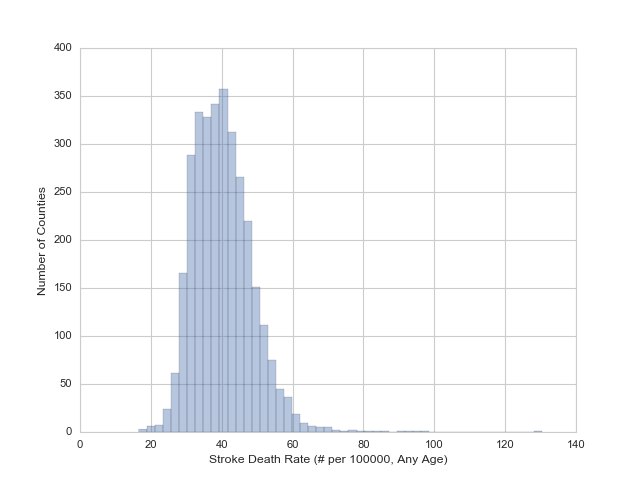

In [4]:
dist = sns.distplot (stroke_death_smoothed_data['Value'].dropna (), kde=False)
dist.set (xlabel='Stroke Death Rate (# per 100000, Any Age)', 
          ylabel='Number of Counties')

In [5]:
# For correlation plots, remove:
#     FIPS, State, County, 
#     demographic specific blood pressure med. adherence,
#     hospital number, specialist number
cols = stroke_death_smoothed_data.columns.tolist ()
cols_subset = cols
remove_cols = ['FIPS', 'County', 'State', 'htnadh_white', 
               'htnadh_black', 'htnadh_api', 'htnadh_aian', 
               'htnadh_hisp', 'stg_hosp', 'stg_int_cr', 
               'stg_rehab', 'stg_emerg', 'stg_neuro', 'cvd_dr', 
               'neuro_dr', 'surg_dr']
for col in remove_cols:
    cols_subset.remove (col)
    
print (len (cols_subset))

31


<IPython.core.display.Javascript object>


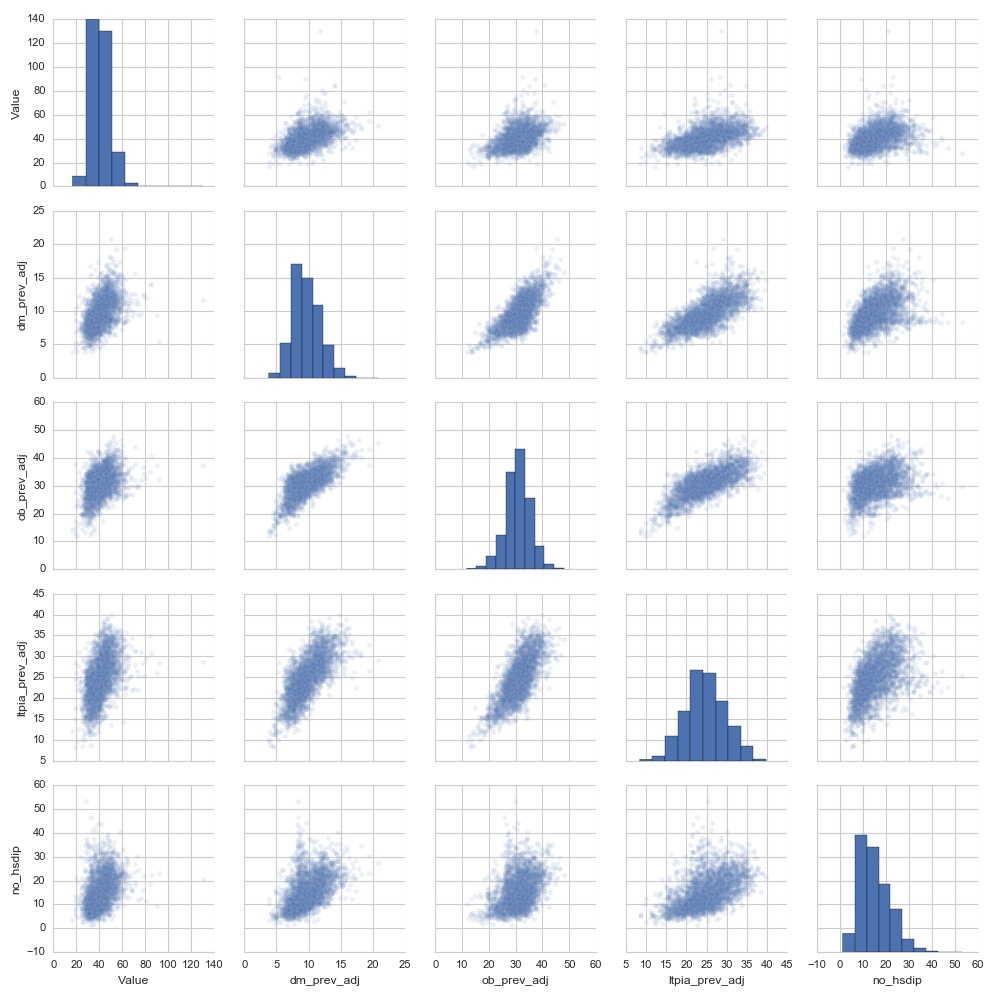

<IPython.core.display.Javascript object>


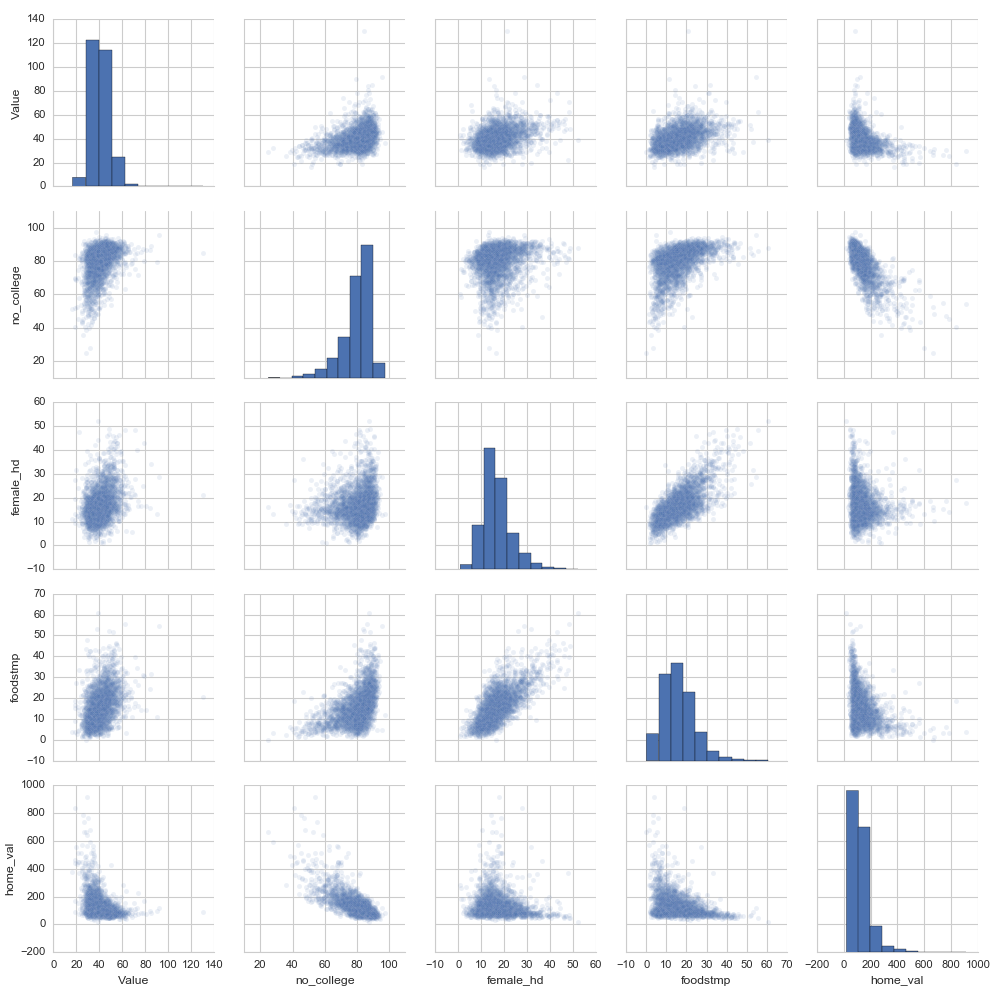

<IPython.core.display.Javascript object>


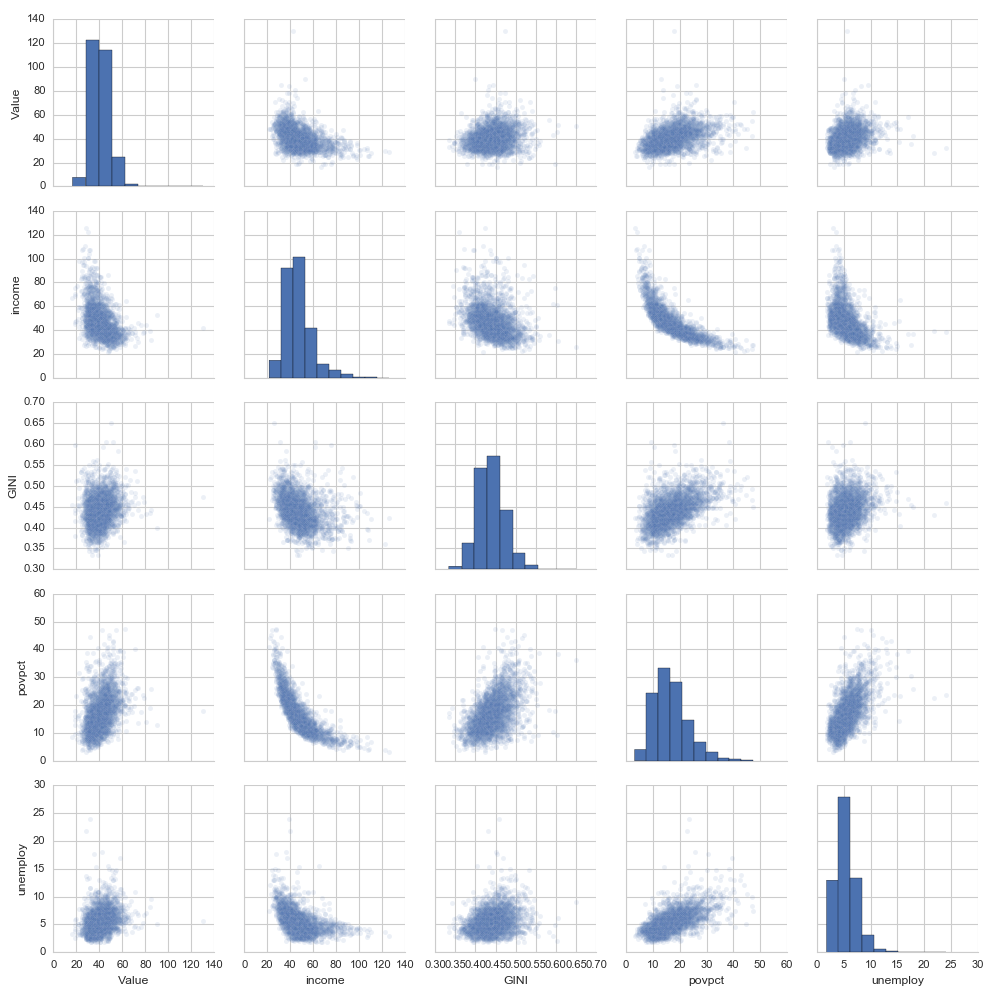

<IPython.core.display.Javascript object>


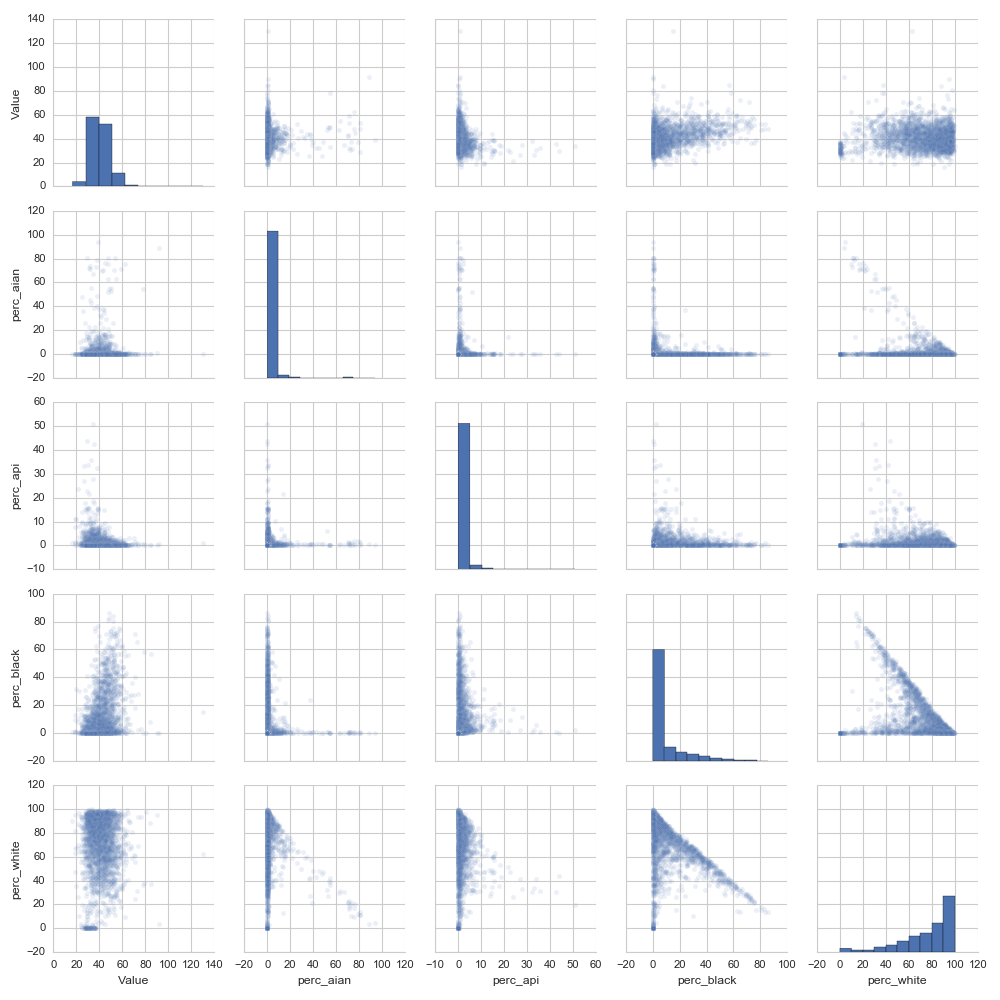

<IPython.core.display.Javascript object>


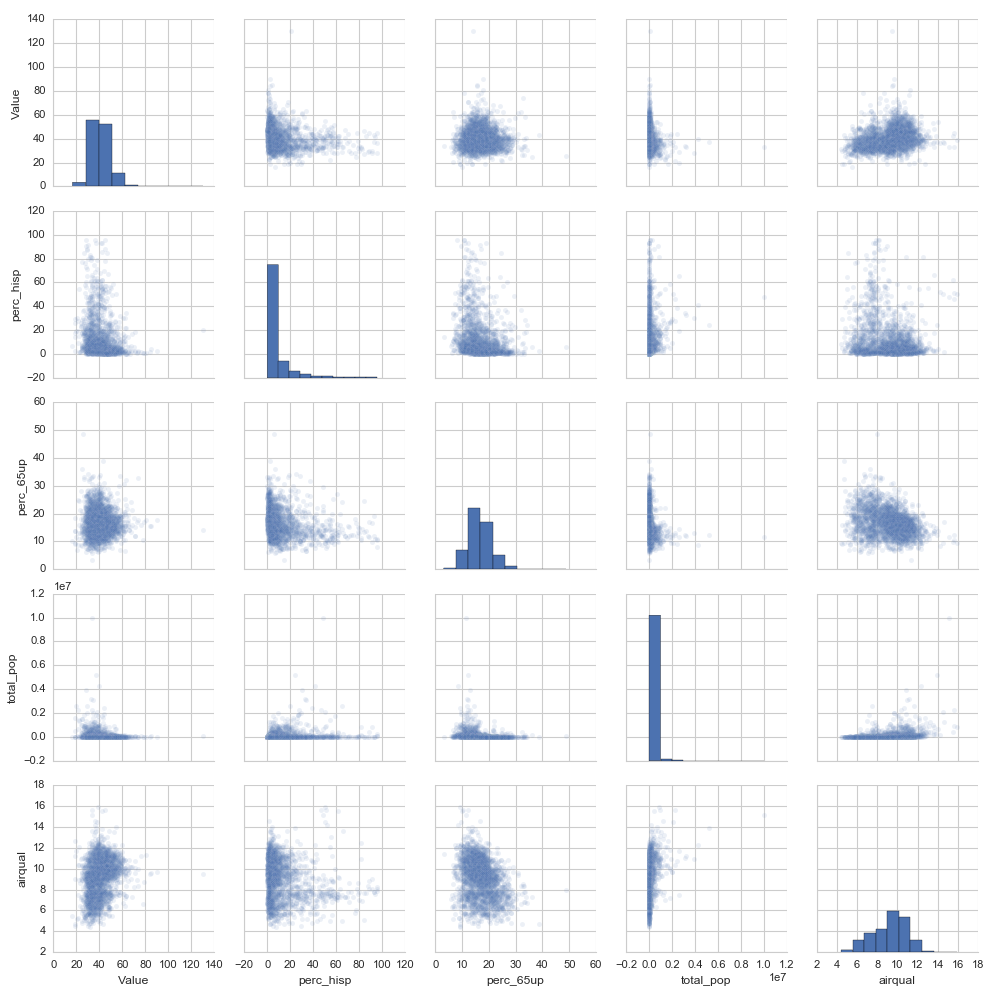

<IPython.core.display.Javascript object>


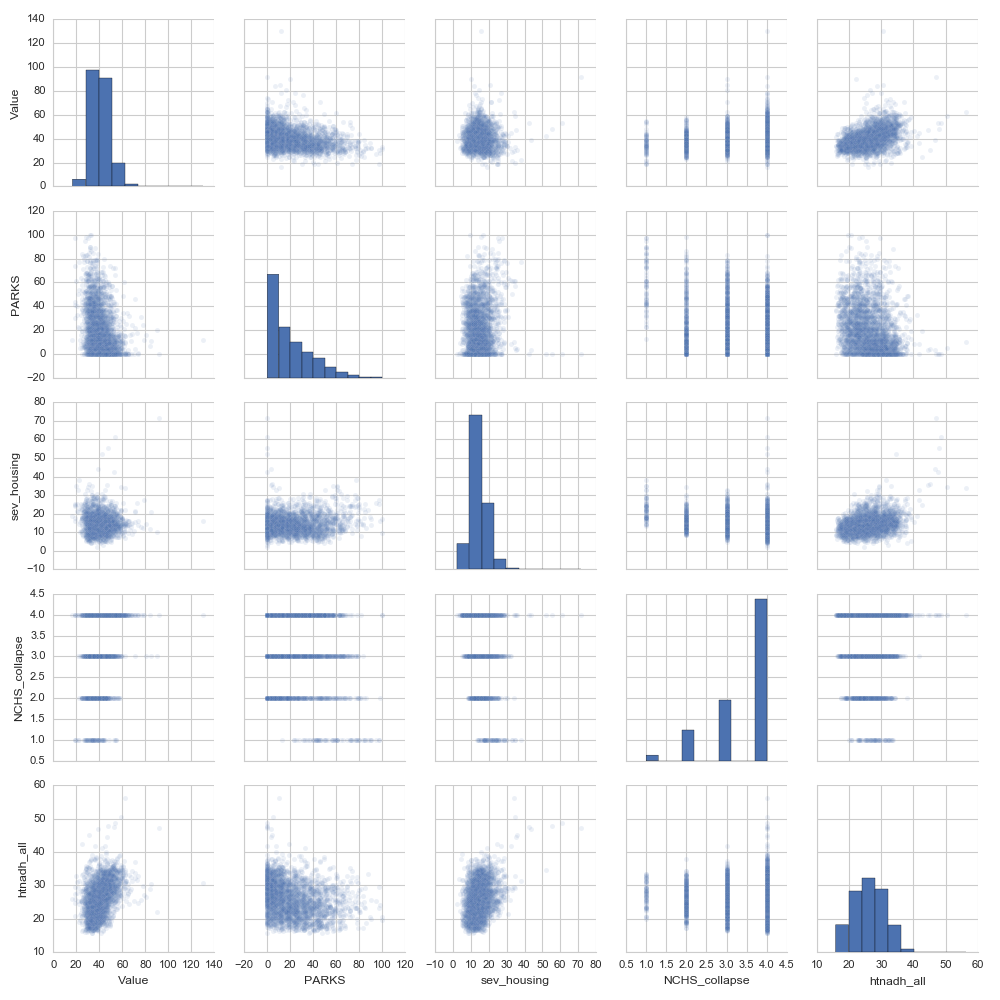

<IPython.core.display.Javascript object>


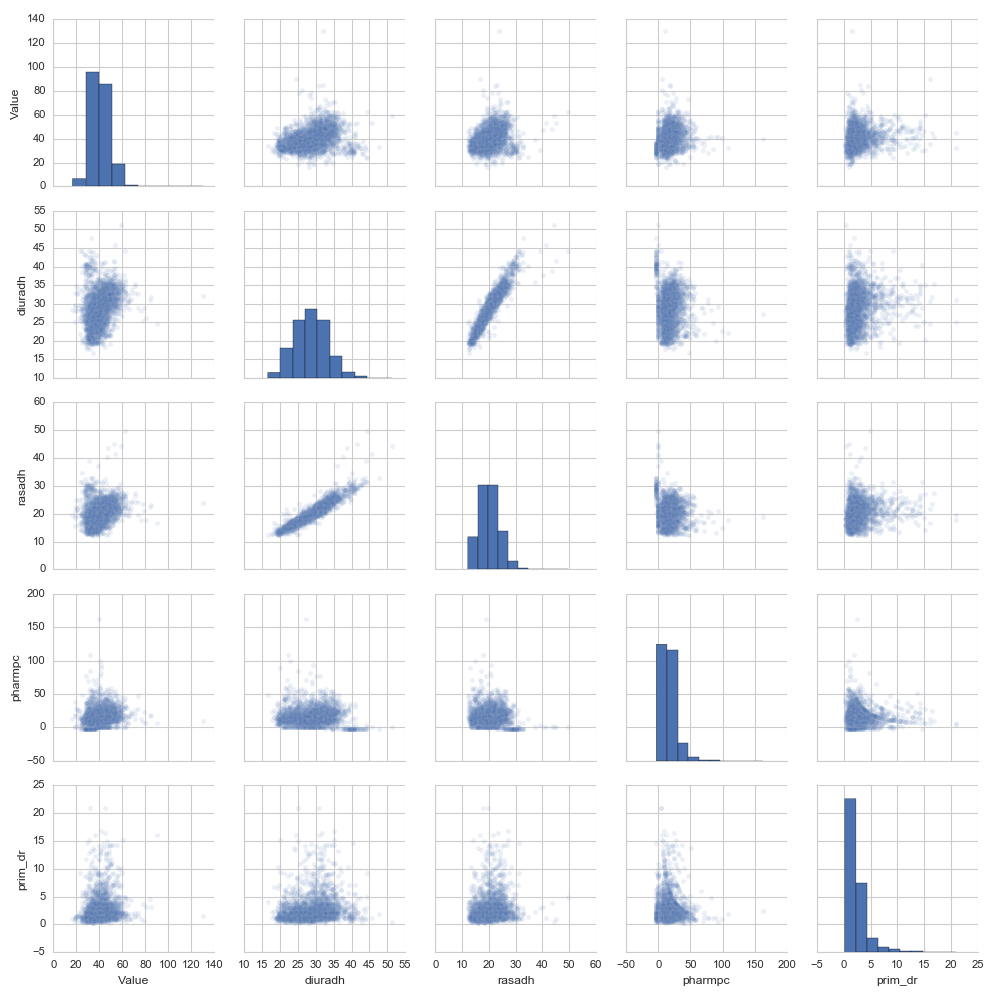

<IPython.core.display.Javascript object>


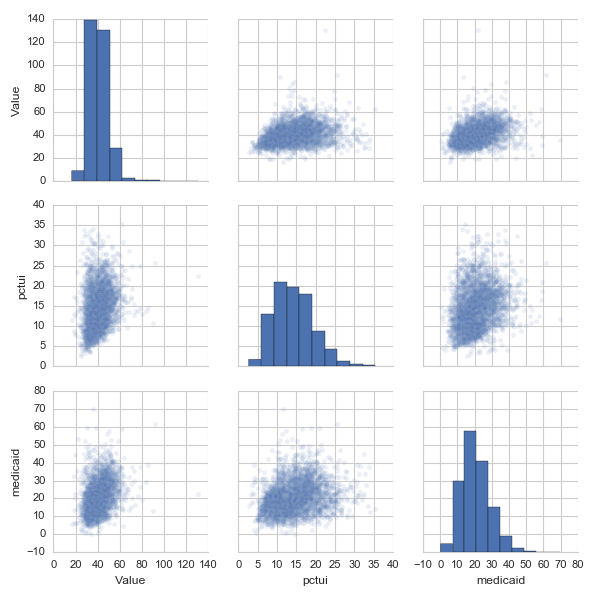

In [6]:
sns.pairplot (stroke_death_smoothed_data[cols_subset[:5]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[5:9]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[9:13]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[13:17]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[17:21]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[21:25]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[25:29]].dropna (),
              plot_kws=dict(alpha=0.1))
sns.pairplot (stroke_death_smoothed_data[cols_subset[0:1] + cols_subset[29:]].dropna (),
              plot_kws=dict(alpha=0.1))

In [13]:
def normalize_data (data):
    mu = []
    sigma = []
    data_norm = data
    for col in data.columns:
        mu_col = data.loc[:, col].mean ()
        sigma_col = data.loc[:, col].std ()
        data_norm.loc[:, col] = (data.loc[:, col] - mu_col) / sigma_col
        mu.append (mu_col)
        sigma.append (sigma_col)
        
    return (data_norm, mu, sigma)

In [14]:
data_no_nans = stroke_death_smoothed_data[cols_subset].dropna ()
y_stroke_death_smoothed = data_no_nans['Value']
X_stroke_death_smoothed_data_subset = data_no_nans[cols_subset[1:]]

In [15]:
X_stroke_death_smoothed_data_subset_norm, mu, sigma = \
    normalize_data (X_stroke_death_smoothed_data_subset)

In [16]:
X_stroke_death_smoothed_data_subset_norm.head ()

,dm_prev_adj,ob_prev_adj,ltpia_prev_adj,no_hsdip,no_college,female_hd,foodstmp,home_val,income,GINI,povpct,unemploy,perc_aian,perc_api,perc_black,perc_white,perc_hisp,perc_65up,total_pop,airqual,PARKS,sev_housing,NCHS_collapse,htnadh_all,diuradh,rasadh,pharmpc,prim_dr,pctui,medicaid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.006902,0.612772,0.640532,-0.179186,-0.189111,-0.053803,-0.215737,0.048440,0.595940,-0.888037,-0.595372,-0.181885,-0.167095,-0.131267,0.637745,-0.082425,-0.458771,-0.798259,-0.157688,1.037049,0.000000,-0.210126,-0.546840,0.680280,0.959845,0.441072,-0.532512,0.217880,-0.630848,-0.660517
1,-0.420814,-0.803181,-0.714965,-0.617902,-0.931069,-0.306124,-0.570630,0.467543,0.208074,0.328569,-0.611162,-0.024406,-0.167095,-0.264637,0.011442,0.274503,-0.306129,0.262190,0.252582,0.064087,-0.791930,0.042535,-0.546840,0.121282,0.048856,0.161117,0.113230,-0.578833,0.392225,-0.940374
2,3.309668,2.951238,1.238545,1.575677,0.730031,1.854370,1.006671,-0.564595,-1.005040,0.595629,1.346777,1.760355,-0.220958,-0.398007,2.544182,-1.639457,-0.290865,-0.268034,-0.242164,0.793809,-0.844725,0.708639,0.706606,0.928723,0.726258,0.749023,0.849921,-0.157044,0.231743,0.604920
3,1.881953,2.007270,1.697022,1.076449,1.106547,0.450838,0.375751,-0.476089,-0.625426,-0.116531,0.194119,0.553017,-0.113232,-0.531378,0.823571,-0.160018,-0.496931,-0.581349,-0.255630,0.976239,-1.055906,-0.347940,-1.800285,0.804502,0.586106,0.609046,0.095040,0.545939,-0.109282,0.166884
4,1.191123,0.848764,0.461128,1.046193,0.885067,-0.574214,0.020858,-0.197555,-0.130278,-0.799017,0.099380,-0.076899,-0.185049,-0.531378,-0.532271,0.533146,-0.008478,-0.147529,-0.150123,1.341100,-1.003111,-0.508724,-1.800285,0.597466,0.702899,0.273099,0.058660,0.405342,0.472466,-0.490170


In [17]:
lin_model = LinearRegression ()
lin_model.fit (X_stroke_death_smoothed_data_subset_norm, y_stroke_death_smoothed)

lin_model_few_vars = LinearRegression ()
lin_model_few_vars.fit (X_stroke_death_smoothed_data_subset_norm.iloc[:, 0:5], y_stroke_death_smoothed)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
pred = lin_model.predict (X_stroke_death_smoothed_data_subset_norm)
print (((y_stroke_death_smoothed - pred)**2).sum () / (2. * len (pred)))

pred = lin_model_few_vars.predict (X_stroke_death_smoothed_data_subset_norm.iloc[:, 0:5])
print (((y_stroke_death_smoothed - pred)**2).sum () / (2. * len (pred)))

19.0729625794
22.5724955977


In [22]:
idx = np.abs (lin_model.coef_).argsort ()[::-1]
print (X_stroke_death_smoothed_data_subset_norm.columns[idx])
print (lin_model.coef_[idx])

Index([u'htnadh_all', u'perc_hisp', u'airqual', u'diuradh', u'pctui',
       u'perc_white', u'home_val', u'perc_aian', u'dm_prev_adj',
       u'NCHS_collapse', u'sev_housing', u'perc_65up', u'income',
       u'perc_black', u'GINI', u'povpct', u'medicaid', u'total_pop', u'rasadh',
       u'no_college', u'ob_prev_adj', u'foodstmp', u'PARKS', u'no_hsdip',
       u'prim_dr', u'ltpia_prev_adj', u'pharmpc', u'perc_api', u'unemploy',
       u'female_hd'],
      dtype='object')
[ 2.95987781 -2.56530528  1.51067973 -1.49363041  1.22500556 -1.21967994
 -0.80684663 -0.79602075  0.79595138  0.79343808 -0.7086087  -0.59468352
 -0.58058453 -0.57931488  0.46372171 -0.44078553  0.43000392 -0.33012308
  0.31178221  0.31118134 -0.29803781  0.27829882 -0.23916262  0.22506644
 -0.20417183  0.16633303  0.09823053  0.06812186 -0.05653698 -0.00334159]
